In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



In [18]:
# Carica il dataset
housing_data = pd.read_csv('data/housing.csv')

# Separazione delle feature e del target
X = housing_data.drop(columns=['median_house_value'])
y = housing_data['median_house_value']

# Identificazione delle colonne numeriche e categoriche
numerical_features = X.select_dtypes(include=['float64']).columns.tolist()
categorical_features = ['ocean_proximity']

### Preprocessing delle feature
In questa cella si creano due pipeline per:
- Le colonne numeriche: sostituzione dei valori mancanti con la mediana e normalizzazione.
- Le colonne categoriche: codifica one-hot.
Infine, si combinano le due pipeline in un `ColumnTransformer`.


In [19]:
# Pipeline per le feature numeriche (imputazione + normalizzazione)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline per le feature categoriche (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinazione delle trasformazioni
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Suddivisione e trasformazione dei dati
Divisione del dataset in un training set e un test set. Applica poi le trasformazioni definite nelle pipeline per normalizzare e codificare le feature.


In [20]:
# Suddivisione dei dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione delle trasformazioni ai dati
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


### Creazione e compilazione del modello
Definizione della rete neurale:
- Tre livelli nascosti con 128, 64, e 32 neuroni rispettivamente.
- Funzione di attivazione ReLU per i livelli nascosti.
- Livello di output con un singolo neurone per la regressione.
Compilazione del modello con l'ottimizzatore Adam e la funzione di perdita MSE.


In [21]:
# Definizione del modello
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer per la regressione
])

# Compilazione del modello
model.compile(optimizer='adam', loss='mse', metrics=['mae'])



c:\Users\vinor\Desktop\Develhope\projects\EDU-ArtificialNeuralNetworks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Configurazione dell'early stopping
Configurazione per il callback di early stopping per interrompere l'addestramento se il modello smette di migliorare la perdita sul validation set per 10 epoche consecutive.


In [22]:
# Callback per l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


### Addestramento del modello
Addestramento del modello utilizzando il training set e un validation set derivato dal training set (20%). Si monitora l'andamento della perdita con l'early stopping.


In [23]:
# Addestramento del modello
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Numero massimo di epoche
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 53078192128.0000 - mae: 200056.0469 - val_loss: 16538045440.0000 - val_mae: 94272.7578
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11399346176.0000 - mae: 77334.0156 - val_loss: 6913179136.0000 - val_mae: 57879.0977
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6273338368.0000 - mae: 55492.1992 - val_loss: 5549625344.0000 - val_mae: 52701.7148
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5131119104.0000 - mae: 50994.3906 - val_loss: 5090808832.0000 - val_mae: 51060.5938
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4738066432.0000 - mae: 49739.5469 - val_loss: 4917382656.0000 - val_mae: 50287.0977
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4661643264.0000 - mae: 49308.7617 - val_loss: 4834527232.0000 - val_mae: 49803.9375
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4569442816.0000 - mae: 48381.2383 - val_loss: 4789650944.0000 - v

### Valutazione del modello
Valutazione dell modello sul test set, calcolando la perdita (MSE) e l'errore assoluto medio (MAE).


In [24]:
# Valutazione del modello
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 3828001280.0000 - mae: 43379.9961
Test Loss: 3852215296.0, Test MAE: 43269.91015625


### Visualizzazione dell'andamento dell'apprendimento
Questa cella visualizza l'andamento della funzione di perdita (`loss`) durante l'addestramento per il training set e il validation set. Questo grafico consente di identificare eventuali problemi, come l'overfitting.

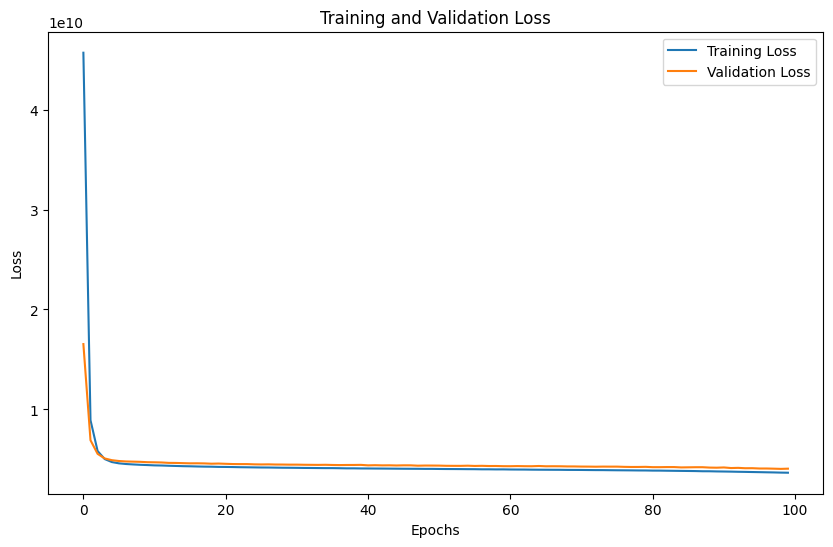

In [25]:
# Grafico dell'andamento dell'apprendimento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
# Previsioni sul set di test
y_pred = model.predict(X_test)

# Calcolo delle metriche
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
Mean Absolute Error (MAE): 43269.91069846929
Mean Squared Error (MSE): 3852216094.9526596
Root Mean Squared Error (RMSE): 62066.2234629485
R-squared (R2): 0.7060294794283312


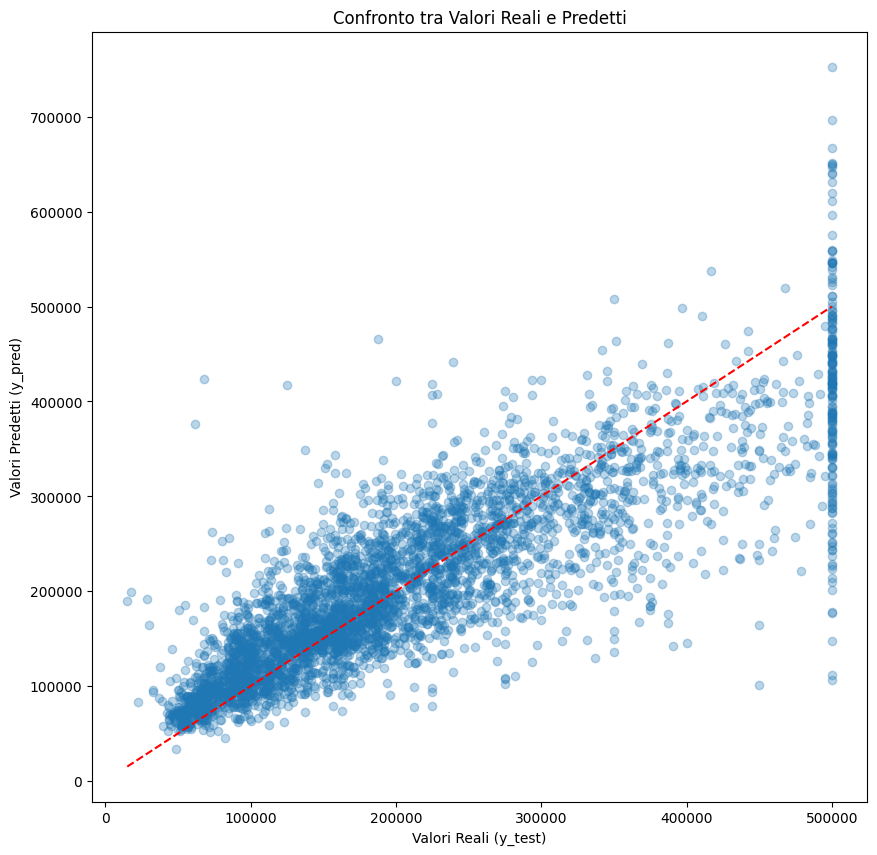

In [27]:
# Grafico di confronto tra valori reali e predetti
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valori Reali (y_test)")
plt.ylabel("Valori Predetti (y_pred)")
plt.title("Confronto tra Valori Reali e Predetti")
plt.show()


# Hyper parameters optimization

In [28]:
# Funzione per definire il modello con iperparametri variabili
def build_model(hp):
    model = Sequential()
    # Primo livello: il numero di neuroni può variare tra 32 e 256
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    # Secondo livello opzionale
    if hp.Boolean('add_second_layer'):
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                        activation='relu'))
    # Livello di output
    model.add(Dense(1))  # Nessuna attivazione per regressione

    # Compilazione del modello
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

- Scopo: Creare una rete neurale in cui gli iperparametri possono essere variati dinamicamente.
- Iperparametri variabili:
    - units_1: Numero di neuroni nel primo layer, varia tra 32 e 256 con step di 32.
    - add_second_layer: Se aggiungere un secondo layer o no (scelta booleana).
    - units_2: Numero di neuroni nel secondo layer (se presente), varia tra 32 e 256.
    - learning_rate: Tasso di apprendimento dell'ottimizzatore, scelto tra 3 valori ([0.01, 0.001, 0.0001]).
- Compilazione:
    - Ottimizzatore: Adam.
    - Loss Function: Mean Squared Error (MSE), usata per regressione.
    - Metriche: Mean Absolute Error (MAE), utile per valutare errori medi.


In [29]:
# Creazione del tuner per cercare i migliori iperparametri
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_tuner',
    project_name='house_price_prediction'
)

Reloading Tuner from my_tuner\house_price_prediction\tuner0.json


- Hyperband: Algoritmo efficiente per il tuning degli iperparametri.
- Parametri:
    - build_model: La funzione che definisce il modello.
    - objective: La metrica da ottimizzare (minimizzare val_loss).
    - max_epochs: Numero massimo di epoche per ogni modello.
    - factor: Riduce il numero di modelli addestrati ad ogni iterazione (fattore di efficienza).
    - directory: Dove salvare i risultati intermedi.
    - project_name: Nome del progetto per identificare i dati salvati.

Hyperband è un algoritmo di ottimizzazione che combina Random Search con un approccio iterativo per allocare risorse in modo intelligente. L'idea principale è addestrare molti modelli inizialmente con poche risorse (ad esempio poche epoche) e poi concentrarsi sui modelli più promettenti man mano che si aggiungono risorse.

- factor controlla il rateo con cui si riduce il numero di modelli da considerare ad ogni iterazione.
    - Un valore di factor=3 significa che:
        - Solo 1/3 dei modelli iniziali passa al ciclo successivo.
        - Ogni modello nel ciclo successivo riceve 3 volte le risorse (ad esempio, il triplo delle epoche).
- Ad ogni ciclo, Hyperband:
    - Seleziona un set di modelli iniziali.
    - Addestra ciascun modello con un numero ridotto di risorse (es., poche epoche).
    - Scarta una frazione dei modelli meno promettenti.
    - Riassegna le risorse risparmiate ai modelli più promettenti.

In [30]:
# Callback per interrompere l'addestramento se non ci sono miglioramenti
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [31]:
# Ricerca degli iperparametri migliori
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])

- tuner.search: Esegue la ricerca degli iperparametri migliori.
    - Suddivide il training set in un set di addestramento e validazione (20% per validazione).
    - Addestra diversi modelli con combinazioni di iperparametri.
    - Usa il callback early_stopping per interrompere l'addestramento di modelli che non migliorano.

In [32]:
# Mostrare i migliori iperparametri trovati
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Migliori iperparametri trovati:")
print(f" - Unità nel primo livello: {best_hps.get('units_1')}")
if best_hps.get('add_second_layer'):
    print(f" - Unità nel secondo livello: {best_hps.get('units_2')}")
print(f" - Learning rate: {best_hps.get('learning_rate')}")


Migliori iperparametri trovati:
 - Unità nel primo livello: 256
 - Unità nel secondo livello: 224
 - Learning rate: 0.01


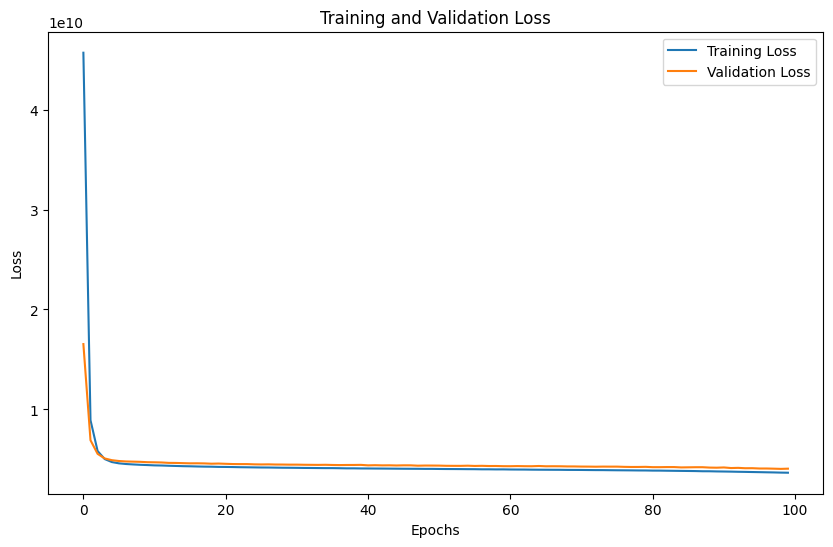

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [34]:
# Costruzione del modello con i migliori iperparametri
best_model = tuner.hypermodel.build(best_hps)

# Addestramento del modello con i migliori iperparametri
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])


Epoch 1/50


c:\Users\vinor\Desktop\Develhope\projects\EDU-ArtificialNeuralNetworks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30392655872.0000 - mae: 130025.7344 - val_loss: 4866013184.0000 - val_mae: 49844.5391
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4596408832.0000 - mae: 49181.8945 - val_loss: 4704815104.0000 - val_mae: 49223.0859
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4403483648.0000 - mae: 47884.1289 - val_loss: 4778813440.0000 - val_mae: 47976.0703
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4366994944.0000 - mae: 47029.8633 - val_loss: 4572436992.0000 - val_mae: 47680.3359
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4428865536.0000 - mae: 47095.2109 - val_loss: 4519948800.0000 - val_mae: 47585.2070
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4269470976.0000 - mae: 46706.6953 - val_loss: 4494199808.0000 - val_mae: 46794.3672
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4276805632.0000 - mae: 46614.0625 - val_loss: 4526233600.0000 - val_mae: 47802.6172
E

In [36]:
y_pred = best_model.predict(X_test)

# Calcolo delle metriche
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error (MAE): 41253.44841251817
Mean Squared Error (MSE): 3574310582.54749
Root Mean Squared Error (RMSE): 59785.53823917194
R-squared (R2): 0.7272370197474025


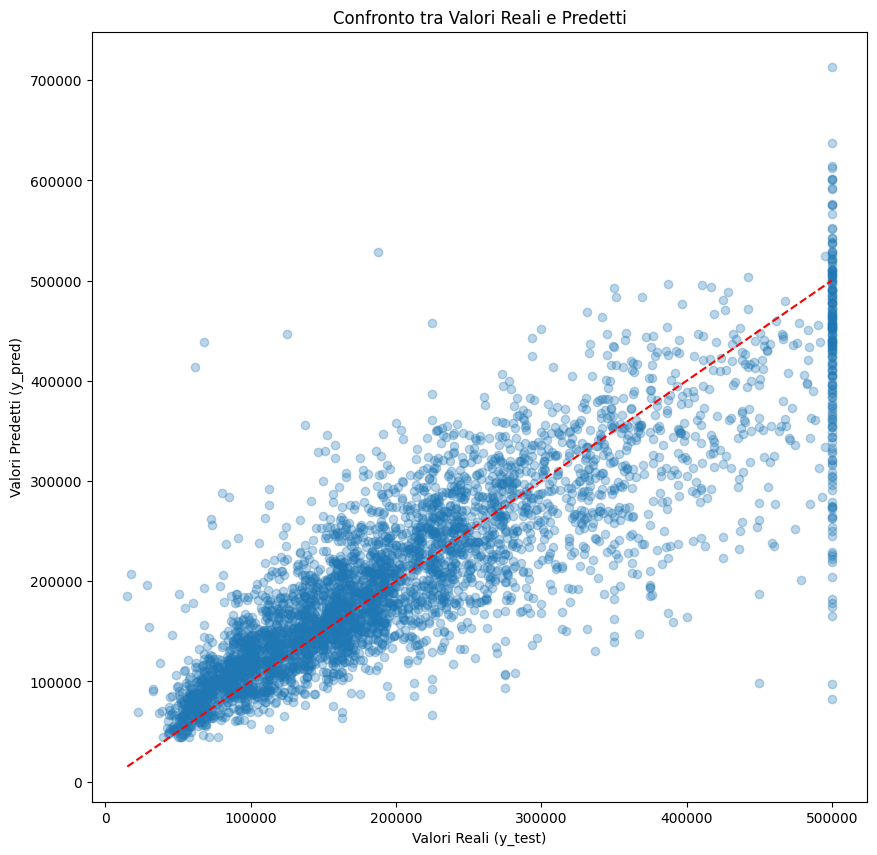

In [37]:
# Grafico di confronto tra valori reali e predetti
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valori Reali (y_test)")
plt.ylabel("Valori Predetti (y_pred)")
plt.title("Confronto tra Valori Reali e Predetti")
plt.show()
